In [1]:
%plot
% define surftat toolbox dir
addpath('/Users/kanaan/SCR/Github/Tourettome/algorithms/surfstats/software/surfstat_chicago')
%% Input/Output 
tourettome_dir = '/Users/kanaan/SCR/workspace/project_touretome/';
freesurfer_dir = [tourettome_dir 'freesurfer/'];
fsaverage5_dir = [freesurfer_dir 'fsaverage5/surf_fsa5/'];
results_dir    = [freesurfer_dir '/cortical_thickness/STATISTICS/'];

phenotypic = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/SEPT10/phenotypic/qsm_surfstat.csv';

% blue cmap
ice = textread('ice.m');

CT20_raw = dlmread('/Users/kanaan/SCR/workspace/project_touretome/derivatives/OLD/feature_matrices/tourettome_sca_raw.csv');
mask  = mean(CT20_raw,1) > 0.4;

In [2]:
surf_sphere = SurfStatReadSurf({[fsaverage5_dir 'lh.sphere'],[fsaverage5_dir 'rh.sphere']});
surf_curv   = SurfStatReadData({[fsaverage5_dir 'fsaverage_curv_lh.asc'],[fsaverage5_dir 'fsaverage_curv_rh.asc']});
surf_infl   = SurfStatReadSurf({[fsaverage5_dir 'lh.inflated'],[fsaverage5_dir 'rh.inflated']});
surf_white  = SurfStatReadSurf({[fsaverage5_dir 'lh.white'],[fsaverage5_dir 'rh.white']});
surf_pial   = SurfStatReadSurf({[fsaverage5_dir 'lh.pial'],[fsaverage5_dir 'rh.pial']});

surf_mid_ct.tri   = surf_white.tri;
surf_mid_ct.coord = (surf_white.coord + surf_white.coord)./2;

In [3]:
phenotypic_fid  = fopen(phenotypic);
phenotypic_data = textscan(phenotypic_fid,'%s%f%s%s%f%f%f%f%f%f%f%f%f%f%f','Delimiter',',','headerLines',1,'CollectOutput',1);
fclose(phenotypic_fid);


% Age Gender 	Group 	QC_PCA 	STR3_MOTOR 	STR3_LIMBIC 	STR3_EXEC 	Caud_Puta 	L_Caud_Puta 	R_Caud_Puta 	L_Caud 	R_Caud 	L_Puta 	R_Puta
    
% subject 	Age 	Group 	Sex 	Site
phenotypic_id         = phenotypic_data{1};
phenotypic_age        = phenotypic_data{2};
phenotypic_sex        = phenotypic_data{3}(:,1);
phenotypic_group      = phenotypic_data{3}(:,2);
phenotypic_qc         = phenotypic_data{4}(:,1);
phenotypic_STRM       = phenotypic_data{4}(:,2);
phenotypic_STRL       = phenotypic_data{4}(:,3);
phenotypic_STRE       = phenotypic_data{4}(:,4);
phenotypic_STR        = phenotypic_data{4}(:,5);
phenotypic_STR_L      = phenotypic_data{4}(:,6);
phenotypic_STR_R      = phenotypic_data{4}(:,7);
phenotypic_PUT_L      = phenotypic_data{4}(:,8);
phenotypic_PUT_R      = phenotypic_data{4}(:,9);
phenotypic_CAU_L      = phenotypic_data{4}(:,10);
phenotypic_CAU_R      = phenotypic_data{4}(:,11);

In [80]:

base_dir ='/Users/kanaan/SCR/workspace/tmp_qsm_surf/SURF/';

qsm_lh = strcat(base_dir,  phenotypic_id, '_depth3_lh_fs5_20fwhmQSM.mgh');
qsm_rh = strcat(base_dir,  phenotypic_id, '_depth3_rh_fs5_20fwhmQSM.mgh');

% load all subject data into a matrix
QSM20  = zeros(length(phenotypic_id),size(surf_white.coord,2));
for i = 1:length(phenotypic_id)
    try
       lh      = SurfStatReadData1(qsm_lh{i}); 
       rh      = SurfStatReadData1(qsm_rh{i}); 
       QSM20(i,:)  = [lh, rh];
    end
end


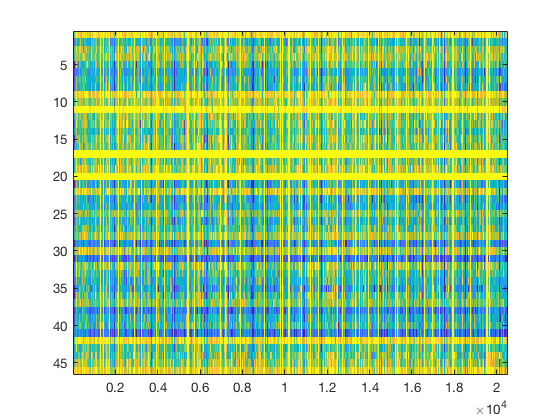

In [81]:
imagesc(QSM20, [-60,.20])



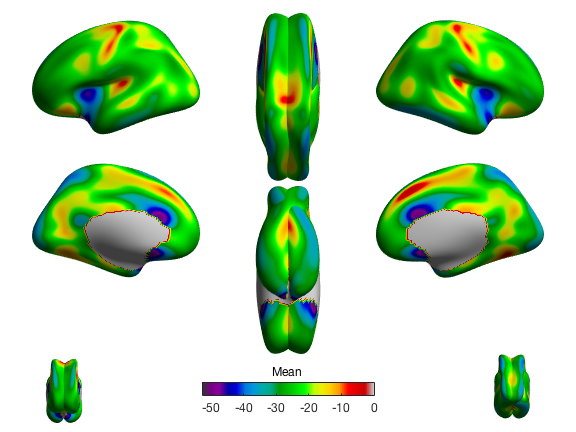

In [82]:
% visualize mean CT of tourettome subject 
SurfStatViewData(mean(QSM20,1), surf_infl, 'Mean');

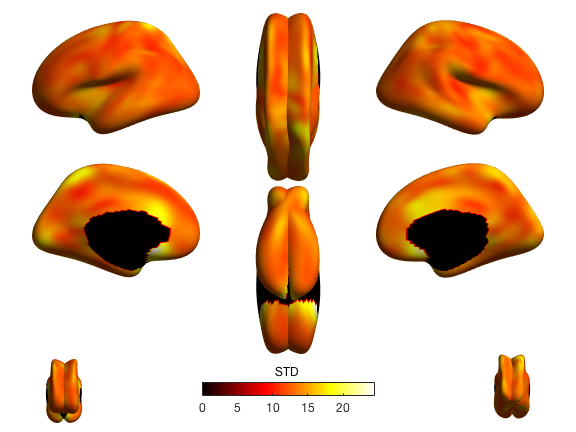

In [83]:
% this is the standard deviation across cases     
SurfStatViewData(std(QSM20,0,1),surf_infl, 'STD');
colormap(hot)

In [96]:
% code variables of interest as terms 
term_age    = term(phenotypic_age);
term_group  = term(phenotypic_group);
term_sex    = term(phenotypic_sex);
term_qc     = term(phenotypic_qc);

df_model    = 1 + term_age + term_group +term_sex + term_qc;
stat_model  = SurfStatLinMod(QSM20,df_model,surf_white);
stat_model  = SurfStatT(stat_model,term_group.controls - term_group.patients); 


% get resid
%df_model  = 1 + term_age + term_sex + term_qc;

%stat_model = SurfStatLinMod(QSM20,df_model,surf_white);
%Resid      = QSM20 - stat_model.X*stat_model.coef;
%imagesc(Resid)

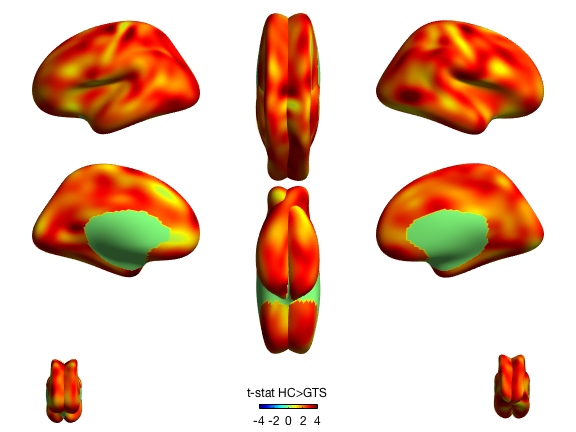

In [97]:
SurfStatViewData(stat_model.t,surf_infl,'t-stat HC>GTS');
SurfStatColLim([-4 4]) ;
colormap(jet)

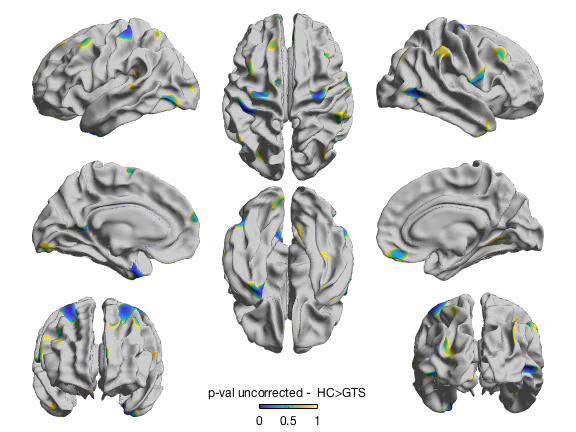

In [99]:
% alternative 1: none - we show uncorrected p-values, good for exploration
p = 1-tcdf(stat_model.t,stat_model.df); 
SurfStatViewData(p,surf_white,'p-val uncorrected -  HC>GTS');
SurfStatColLim([0 0.001]) ;
colormap([parula; .8 .8 .8])

# %fdr 
qval = SurfStatQ(stat_model, mask);
%SurfStatViewData(qval.Q,surf_white,'p-val FDR -  HC>GTS');
%SurfStatColLim([0 0.05]) ;
%colormap([parula; .8 .8 .8])


In [88]:
% code variables of interest as terms 
term_age    = term(phenotypic_age);
term_group  = term(phenotypic_group);
term_sex    = term(phenotypic_sex);
term_qc     = term(phenotypic_qc);

df_model    = 1 + term_age + term_group +term_sex;
stat_model  = SurfStatLinMod(QSM20,df_model,surf_white);
stat_model  = SurfStatT(stat_model,term_group.controls - term_group.patients); 


% get resid
%df_model  = 1 + term_age + term_sex + term_qc;

%stat_model = SurfStatLinMod(QSM20,df_model,surf_white);
%Resid      = QSM20 - stat_model.X*stat_model.coef;
%imagesc(Resid)

# Covariance 

In [89]:
% code variables of interest as terms 
term_age    = term(phenotypic_age);
term_group  = term(phenotypic_group);
term_sex    = term(phenotypic_sex);
term_qc     = term(phenotypic_qc);
term_seed   = term(phenotypic_STRE);


df_model = 1 + term_age + term_sex + term_qc + term_group + term_seed + term_group * term_seed;
%df_model = 1 + term_group + term_seed + term_group * term_seed;
stat_model  = SurfStatLinMod(QSM20,df_model,surf_white);
stat_model  = SurfStatT(stat_model,term_group.controls*term_seed - term_group.patients*term_seed); 


> In * (line 3)
> In * (line 3)


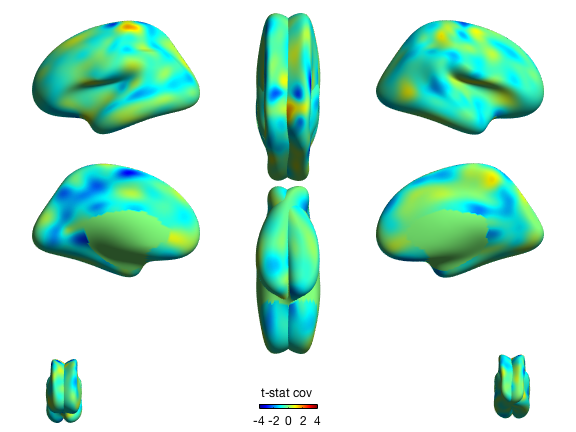

In [90]:
SurfStatViewData(stat_model.t,surf_infl,'t-stat cov');
SurfStatColLim([-4 4]) ;
colormap(jet)

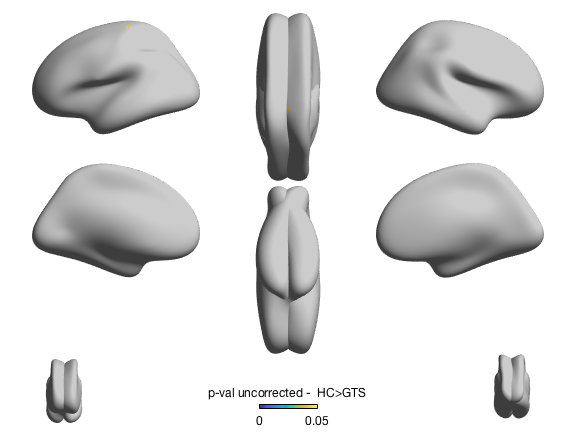

In [91]:
% alternative 1: none - we show uncorrected p-values, good for exploration
p = 1-tcdf(stat_model.t,stat_model.df); 
SurfStatViewData(p,surf_infl,'p-val uncorrected -  HC>GTS');
SurfStatColLim([0 0.05]) ;
colormap([parula; .8 .8 .8])